In [ ]:
!pip install yahoo-historical
!pip install snscrape

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from yahoo_historical import Fetcher
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, load_model
from keras.layers.wrappers import TimeDistributed
from keras.layers import Conv2D, Dense, Dropout, Activation, Flatten, MaxPooling2D, LSTM
from keras.optimizers import SGD
from nltk import word_tokenize
from nltk.corpus import stopwords
from statsmodels.tsa.stattools import adfuller
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
from nltk.corpus import wordnet
from wordcloud import WordCloud
import seaborn as sns
from collections import Counter
import snscrape.modules.twitter as sntwitter
import os, nest_asyncio, csv, re, nltk, datetime

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')

nest_asyncio.apply()
sia = SentimentIntensityAnalyzer()
pd.set_option('display.max_columns', None)
stopword_list = stopwords.words('english')
lemmatizer = WordNetLemmatizer()
%matplotlib inline

STOCK = 'AAPL'

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


# Historical Data Analysis

In [ ]:
df = Fetcher(STOCK, [2013,1,1], [2020,1,1]).get_historical()
# df = pd.read_csv('AAPL_data.csv')
labels = df['Date'].values
df = df['Open'].values
df = df.reshape(-1, 1)
print(df[:10])
print(df.shape)
print()
print(labels[:10])
print(labels.shape)

[[19.779285]
 [19.567142]
 [19.1775  ]
 [18.642857]
 [18.900356]
 [18.660713]
 [18.876785]
 [18.607143]
 [17.952856]
 [17.796429]]
(1762, 1)

['2013-01-02' '2013-01-03' '2013-01-04' '2013-01-07' '2013-01-08'
 '2013-01-09' '2013-01-10' '2013-01-11' '2013-01-14' '2013-01-15']
(1762,)


In [ ]:
COUNT = np.count_nonzero(labels >= '2019-07-01')
print(COUNT)
df_train, df_test = np.array(df[:-COUNT]), np.array(df[-(COUNT + 50):])

# df_train, df_test = np.array(df[:int(df.shape[0] * 0.8)]), np.array(df[int(df.shape[0] * 0.8) - 50:])
print(df_train.shape)
print(df_test.shape)

128
(1634, 1)
(178, 1)


In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))
df_train = scaler.fit_transform(df_train)
df_test = scaler.transform(df_test)
print(df_train[:5])
print(df_test[:5])

[[0.13511311]
 [0.13027396]
 [0.12138593]
 [0.1091903 ]
 [0.11506406]]
[[0.84226346]
 [0.8406097 ]
 [0.84973397]
 [0.86644291]
 [0.86342048]]


In [ ]:
def create_out(df):
  x, y = [], []
  for i in range(50, df.shape[0]):
      x.append(df[i-50:i, 0])
      y.append(df[i, 0])
  x, y = np.array(x), np.array(y)
  return x, y

X_train, y_train = create_out(df_train)
X_test, y_test = create_out(df_test)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Sentiment Analysis

## 1. Gather Data

In [ ]:
users = ['MarketWatch', 'business', 'YahooFinance', 'TechCrunch', 'WSJ', 'Forbes',
         'FT', 'TheEconomist', 'nytimes', 'Reuters', 'GerberKawasaki', 'jimcramer',
         'TheStreet', 'TheStalwart', 'TruthGundlach', 'CarlCIcahn', 'ReformedBroker',
         'benbernanke', 'bespokeinvest', 'BespokeCrypto', 'stlouisfed', 'federalreserve',
         'GoldmanSachs', 'ianbremmer', 'MorganStanley', 'AswathDamodaran', 'mcuban',
         'muddywatersre', 'StockTwits', 'SeanaNSmith']

def fetch_tweets(username):
  scraped_tweets = sntwitter.TwitterUserScraper(username).get_items()
  df = pd.DataFrame(scraped_tweets)[['date', 'content']]
  df = df[(df['date'] > '2019-1-1') & (df['date'] <= '2019-12-31')]
  df.to_csv('Tweets/' + username + '.csv')

for user in users:
  fetch_tweets(user)

In [ ]:
chosen_stocks = pd.read_csv ('stock_tickers.csv', sep=r'\s*,\s*', header=0)
stock_names = chosen_stocks['name'].tolist()
stock_tickers = chosen_stocks['ticker'].tolist()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [ ]:
dataframes = []
for user in users:
  df = pd.read_csv('Tweets/' + user + '.csv')

  df['date'] = pd.to_datetime(df["date"]).dt.strftime('%Y-%m-%d')
  df['content'] = ' ' + df['content'].str.replace('\S*@\S*\s?', '').replace('[^a-zA-Z0-9 ]', '') + ' '
  df['content'] = df['content'].str.lower()
  df['username'] = user
  df['followers'] = api.get_user(user).followers_count

  dataframes.append(df)

data = pd.concat(dataframes)
data.drop(data.columns[[0]], axis=1, inplace=True)

dataframes = []
for i in range(len(chosen_stocks)):
  df = data[data.content.str.contains(' ' + chosen_stocks.at[i, 'name'].lower() + ' ')]
  df['stock'] = chosen_stocks.at[i, 'ticker']
  dataframes.append(df)

data = pd.concat(dataframes)
data.to_csv("tweets.csv")
print(data)

## 2. Clean Data

In [ ]:
tweets = pd.read_csv('tweets.csv', engine='python')
tweets.data_time = pd.to_datetime(tweets.date)
tweets.drop(tweets.columns[[0]], axis=1, inplace=True)
tweets.drop_duplicates(keep=False,inplace=True)
print(tweets.shape)
tweets.head()

(86126, 6)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  


,date,content,username,followers,stock,clean_tweet
0,2019-01-03,novavax shares jump after positive results fo...,MarketWatch,4004317,NVAX,novavax share jmp positive reslt fl vaccine
1,2019-03-14,the wildly successful invesco qqq trust has a...,MarketWatch,4004317,QQQ,wildly sccessfl invesco qqq trst actally perfo...
2,2019-03-10,the invesco qqq trust is now the sixth-larges...,WSJ,18795687,QQQ,invesco qqq trst sixth large etf billion asset
3,2019-12-30,apple stock is rising toward a record even as...,MarketWatch,4004317,AAPL,apple stock rise toward record even overall ma...
4,2019-12-23,apple iphone demand will soar in 2020 with la...,MarketWatch,4004317,AAPL,apple iphone demand soar lanch g wedbsh analyst


In [ ]:
tweets['clean_tweet'] = tweets.content.map(lambda x: x + " ")
tweets.clean_tweet = tweets.clean_tweet.map(lambda x: re.sub(r'http.*', '', x))
tweets.clean_tweet = tweets.clean_tweet.map(lambda x: re.sub(r"[^a-zA-Z#]", ' ', x))
tweets.clean_tweet = tweets.clean_tweet.map(lambda x: x.lower())

tweets.head()

,date,content,username,followers,stock,clean_tweet
0,2019-01-03,novavax shares jump after positive results fo...,MarketWatch,4004317,NVAX,novavax shares jump after positive results fo...
1,2019-03-14,the wildly successful invesco qqq trust has a...,MarketWatch,4004317,QQQ,the wildly successful invesco qqq trust has a...
2,2019-03-10,the invesco qqq trust is now the sixth-larges...,WSJ,18795687,QQQ,the invesco qqq trust is now the sixth larges...
3,2019-12-30,apple stock is rising toward a record even as...,MarketWatch,4004317,AAPL,apple stock is rising toward a record even as...
4,2019-12-23,apple iphone demand will soar in 2020 with la...,MarketWatch,4004317,AAPL,apple iphone demand will soar in with la...


In [ ]:
stopword_list = stopwords.words('english')

for i in range(len(tweets)):
  tokens = word_tokenize(tweets.iloc[i]['clean_tweet'])
  clean_tokens = [w for w in tokens if w not in stopword_list]
  tweets.clean_tweet[i] = clean_tokens
tweets.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,date,content,username,followers,stock,clean_tweet
0,2019-01-03,novavax shares jump after positive results fo...,MarketWatch,4004317,NVAX,"[novavax, shares, jump, positive, results, flu..."
1,2019-03-14,the wildly successful invesco qqq trust has a...,MarketWatch,4004317,QQQ,"[wildly, successful, invesco, qqq, trust, actu..."
2,2019-03-10,the invesco qqq trust is now the sixth-larges...,WSJ,18795687,QQQ,"[invesco, qqq, trust, sixth, largest, etf, bil..."
3,2019-12-30,apple stock is rising toward a record even as...,MarketWatch,4004317,AAPL,"[apple, stock, rising, toward, record, even, o..."
4,2019-12-23,apple iphone demand will soar in 2020 with la...,MarketWatch,4004317,AAPL,"[apple, iphone, demand, soar, launch, g, wedbu..."


In [ ]:
for i in range(len(tweets)):
  for word in [tweets.iloc[i]['clean_tweet']]:
    pos_tag_list = nltk.pos_tag(word)

  wordnet_tags = []
  for j in pos_tag_list:
    if j[1].startswith('J'):
      wordnet_tags.append(wordnet.ADJ)
    elif j[1].startswith('N'):
      wordnet_tags.append(wordnet.NOUN)
    elif j[1].startswith('R'):
      wordnet_tags.append(wordnet.ADV)
    elif j[1].startswith('V'):
      wordnet_tags.append(wordnet.VERB)
    else:
      wordnet_tags.append(wordnet.NOUN)

  # Lemmatize each word in tweet
  lem_words = []
  for k in range(len(tweets.iloc[i]['clean_tweet'])):
    lem_words.append(lemmatizer.lemmatize(tweets.iloc[i]['clean_tweet'][k], pos=wordnet_tags[k]))
  lem_tweet = ' '.join(lem_words)
  tweets.clean_tweet[i] = lem_tweet
tweets.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,date,content,username,followers,stock,clean_tweet
0,2019-01-03,novavax shares jump after positive results fo...,MarketWatch,4004317,NVAX,novavax share jump positive result flu vaccine
1,2019-03-14,the wildly successful invesco qqq trust has a...,MarketWatch,4004317,QQQ,wildly successful invesco qqq trust actually p...
2,2019-03-10,the invesco qqq trust is now the sixth-larges...,WSJ,18795687,QQQ,invesco qqq trust sixth large etf billion asset
3,2019-12-30,apple stock is rising toward a record even as...,MarketWatch,4004317,AAPL,apple stock rise toward record even overall ma...
4,2019-12-23,apple iphone demand will soar in 2020 with la...,MarketWatch,4004317,AAPL,apple iphone demand soar launch g wedbush analyst


In [ ]:
tweets.to_csv('tweets.csv')

## 3. EDA

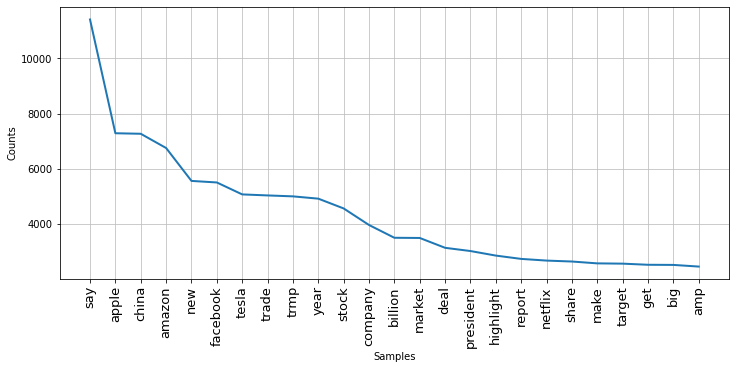

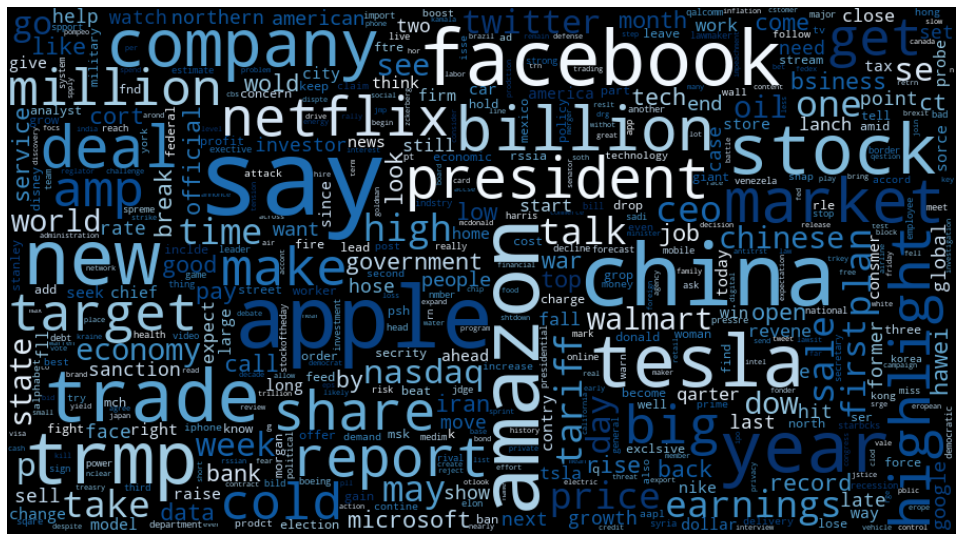

In [ ]:
tweets.clean_tweet = tweets.clean_tweet.map(lambda x: x.replace('u',''))
tweets.clean_tweet = tweets.clean_tweet.map(lambda x: x.replace('#',''))

all_words_string = ' '.join([tweet for tweet in tweets.clean_tweet])
all_words_list = all_words_string.split()

plt.figure(figsize=(12,5))
plt.xticks(fontsize=13, rotation=90)
freq_dist = nltk.FreqDist(all_words_list)
freq_dist.plot(25, cumulative=False)

wordcloud = WordCloud(width=900, height=500, max_words=500, max_font_size=100, relative_scaling=0.5,
                      colormap='Blues', normalize_plurals=True).generate_from_frequencies(freq_dist)
plt.figure(figsize=(17,14))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
word_freq = nltk.FreqDist(all_words_list)
freq_df = pd.DataFrame({'Word': list(word_freq.keys()), 'Count': list(word_freq.values())}).sort_values(by=['Count'], ascending=False)
freq_df.head(10)

,Word,Count
17,say,11414
23,apple,7290
286,china,7271
52,amazon,6755
134,new,5562
574,facebook,5506
691,tesla,5073
66,trade,5036
121,trmp,5002
95,year,4919


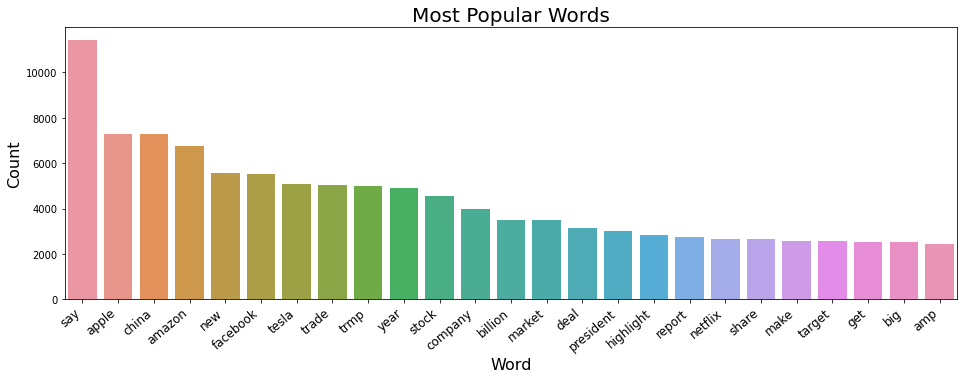

In [ ]:
freq_df = freq_df.nlargest(columns="Count", n = 25) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=freq_df, x= "Word", y = "Count")
ax.set_ylabel('Count', fontsize=16)
ax.set_xlabel('Word', fontsize=16)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize=12)
ax.set_title("Most Popular Words", fontsize=20)
plt.show()

## 4. Vader and TextBlob Sentiment

In [ ]:
tweets = pd.read_csv('tweets.csv', engine='python').drop(['Unnamed: 0'],axis=1)
tweets.set_index(pd.to_datetime(tweets.date), inplace = True)
tweets = tweets.drop(columns = ['date'])
tweets = tweets.dropna()

tweets['sentiment_1'] = tweets.apply(lambda row: sia.polarity_scores(row.clean_tweet)['compound'], axis=1)
tweets['sentiment_2'] = tweets.apply(lambda row: TextBlob(row.clean_tweet).sentiment[0], axis=1)
scaler = MinMaxScaler(feature_range=(-1, 1), copy=True)
tweets['s1_scaled'] = scaler.fit_transform(tweets[['sentiment_1']])
tweets['s2_scaled'] = scaler.fit_transform(tweets[['sentiment_2']])

tweets.head()

,content,username,followers,stock,clean_tweet,sentiment_1,sentiment_2,s1_scaled,s2_scaled
date,,,,,,,,,
2019-01-03,novavax shares jump after positive results fo...,MarketWatch,4004317,NVAX,novavax share jump positive result flu vaccine,0.4939,0.227273,0.499288,0.227273
2019-03-14,the wildly successful invesco qqq trust has a...,MarketWatch,4004317,QQQ,wildly successful invesco qqq trust actually p...,0.8750,0.483333,0.887057,0.483333
2019-03-10,the invesco qqq trust is now the sixth-larges...,WSJ,18795687,QQQ,invesco qqq trust sixth large etf billion asset,0.7003,0.214286,0.709300,0.214286
2019-12-30,apple stock is rising toward a record even as...,MarketWatch,4004317,AAPL,apple stock rise toward record even overall ma...,0.0000,0.000000,-0.003256,0.000000
2019-12-23,apple iphone demand will soar in 2020 with la...,MarketWatch,4004317,AAPL,apple iphone demand soar launch g wedbush analyst,-0.1280,0.000000,-0.133496,0.000000


In [ ]:
# Tweet with the highest & lowest sentiment_1

print(tweets.loc[tweets['sentiment_1'].idxmax()])
print()
print(tweets.loc[tweets['sentiment_1'].idxmin()])

                                                      content        username  \
date                                                                            
2019-03-09   the "smart money" prefers alibaba over amazon...     MarketWatch   
2019-03-09   apple could launch augmented reality headset ...      TechCrunch   
2019-03-09   rio tinto talking to apple on next step of ca...         Reuters   
2019-03-09   rio tinto talking to apple on next step of ca...         Reuters   
2019-03-09   true but it’s different management now. that’...  GerberKawasaki   
...                                                       ...             ...   
2019-03-09   'really bad business practice': u.s. security...     SeanaNSmith   
2019-03-09   a rise in high-income renters is bad news for...     SeanaNSmith   
2019-03-09   operation straw: meet the snorkelers collecti...         Reuters   
2019-03-09   watch: the 'strawklers' scouring australian w...         Reuters   
2019-03-09   watch: the last

In [ ]:
# Tweet with the highest & lowest sentiment_2

print(tweets.loc[tweets['sentiment_2'].idxmax()])
print()
print(tweets.loc[tweets['sentiment_2'].idxmin()])

                                                      content     username  \
date                                                                         
2019-06-27   legendary apple designer jony ive to leave co...  MarketWatch   
2019-06-27   apple stock falls as jony ive leaves to start...  MarketWatch   
2019-06-27   apple stock falls as jony ive leaves to start...  MarketWatch   
2019-06-27   apple's chief designer jony ive is leaving af...     business   
2019-06-27   apple shares sank more than 1% in extended tr...     business   
...                                                       ...          ...   
2019-06-27   china urges u.s. to lift sanctions on huawei ...  SeanaNSmith   
2019-06-27   u.s. jobless claims increase to highest level...  SeanaNSmith   
2019-06-27   fedex sues u.s. government over 'impossible' ...  SeanaNSmith   
2019-06-27   ubs: world economy ‘one step away from global...  SeanaNSmith   
2019-06-27   president duterte backtracks and says china c...   

In [ ]:
stock_prices = Fetcher(STOCK, [2013,1,1], [2020,1,1]).get_historical()
stock_prices.set_index(pd.to_datetime(stock_prices.Date), inplace = True)
stock_prices = stock_prices.drop(columns = ['Date'])
stock_prices['open_close_diff'] = stock_prices.Open - stock_prices.Close.shift(1)
stock_prices['pos_neg'] = stock_prices['pos_neg'] = stock_prices.open_close_diff.apply(lambda x: 1 if (x > 0) else (-1 if x < 0 else 0))
stock_prices = stock_prices.resample('D').asfreq()
stock_prices.head()

,Open,High,Low,Close,Adj Close,Volume,open_close_diff,pos_neg
Date,,,,,,,,
2013-01-02,19.779285,19.821428,19.343929,19.608213,17.039789,560518000.0,NaN,0.0
2013-01-03,19.567142,19.631071,19.321428,19.360714,16.824715,352965200.0,-0.041071,-1.0
2013-01-04,19.177500,19.236786,18.779642,18.821428,16.356062,594333600.0,-0.183214,-1.0
2013-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
print(stock_prices)
daily = pd.merge(stock_prices, tweets, how='inner', left_index=True, right_index=True)
daily = daily.dropna()
daily.head()

                 Open       High        Low      Close  Adj Close  \
Date                                                                
2013-01-02  19.779285  19.821428  19.343929  19.608213  17.039789   
2013-01-03  19.567142  19.631071  19.321428  19.360714  16.824715   
2013-01-04  19.177500  19.236786  18.779642  18.821428  16.356062   
2013-01-05        NaN        NaN        NaN        NaN        NaN   
2013-01-06        NaN        NaN        NaN        NaN        NaN   
...               ...        ...        ...        ...        ...   
2019-12-27  72.779999  73.492500  72.029999  72.449997  71.722488   
2019-12-28        NaN        NaN        NaN        NaN        NaN   
2019-12-29        NaN        NaN        NaN        NaN        NaN   
2019-12-30  72.364998  73.172501  71.305000  72.879997  72.148178   
2019-12-31  72.482498  73.419998  72.379997  73.412498  72.675339   

                 Volume  open_close_diff  pos_neg  
Date                                              

,Open,High,Low,Close,Adj Close,Volume,open_close_diff,pos_neg,content,username,followers,stock,clean_tweet,sentiment_1,sentiment_2,s1_scaled,s2_scaled
2019-01-02,38.7225,39.712502,38.557499,39.48,38.505024,148158800.0,-0.712501,-1.0,"dow, s&amp;p 500, nasdaq stock futures sink a...",MarketWatch,4004317,AAPL,dow amp p nasdaq stock future sink apple cut s...,-0.2732,0.000000,-0.281237,0.000000
2019-01-02,38.7225,39.712502,38.557499,39.48,38.505024,148158800.0,-0.712501,-1.0,tech stocks sell off in after-hours trading a...,MarketWatch,4004317,AAPL,tech stock sell hour trade apple trim forecast,0.0000,0.000000,-0.003256,0.000000
2019-01-02,38.7225,39.712502,38.557499,39.48,38.505024,148158800.0,-0.712501,-1.0,tim cook said apple will report much lower sa...,MarketWatch,4004317,AAPL,tim cook say apple report much low sale previo...,0.0000,-0.083333,-0.003256,-0.083333
2019-01-02,38.7225,39.712502,38.557499,39.48,38.505024,148158800.0,-0.712501,-1.0,apple stock falls as much as 9% after hours f...,MarketWatch,4004317,AAPL,apple stock fall much hour follow company lowe...,-0.2960,0.200000,-0.304436,0.200000
2019-01-02,38.7225,39.712502,38.557499,39.48,38.505024,148158800.0,-0.712501,-1.0,"apple reduces forecast for holiday sales, cit...",MarketWatch,4004317,AAPL,apple reduces forecast holiday sale cite econo...,0.4019,0.200000,0.405678,0.200000


Results of Dickey-Fuller Test:
Test Statistic                -1.025835e+01
p-value                        4.301580e-18
#Lags Used                     0.000000e+00
Number of Observations Used    7.165800e+04
Critical Value (1%)           -3.430441e+00
Critical Value (5%)           -2.861580e+00
Critical Value (10%)          -2.566791e+00
dtype: float64
None
Results of Dickey-Fuller Test:
Test Statistic                -1.111109e+01
p-value                        3.658703e-20
#Lags Used                     0.000000e+00
Number of Observations Used    7.165800e+04
Critical Value (1%)           -3.430441e+00
Critical Value (5%)           -2.861580e+00
Critical Value (10%)          -2.566791e+00
dtype: float64
None


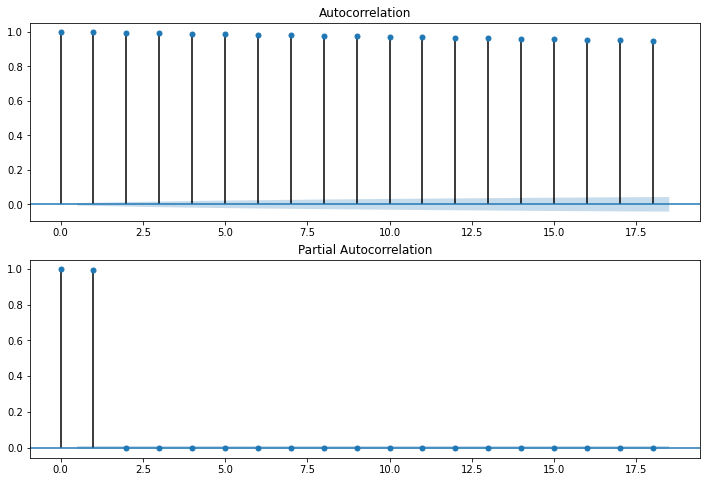

In [ ]:
import statsmodels.api as sm

def check_stationarity(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

print(check_stationarity(daily.open_close_diff))
print(check_stationarity(daily.pos_neg))

def plot_acf_pacf(timeseries):
    fig = plt.figure(figsize=(12,8))
    ax1 = fig.add_subplot(211)
    # Plot the ACF
    fig = sm.graphics.tsa.plot_acf(timeseries.iloc[1:], lags=18, ax=ax1)
    ax2 = fig.add_subplot(212)
    #plot the PACF
    fig = sm.graphics.tsa.plot_pacf(timeseries.iloc[1:], lags=18, ax=ax2)

plot_acf_pacf(daily.open_close_diff)

# 3. LSTM Regressor

In [ ]:
# LSTM
neurons = 32
loss = 'mean_squared_error'
optimizer = 'adam'
dropout = 0.2
batch_size = 32
epochs = 50

model = Sequential()
model.add(LSTM(units=neurons, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(dropout))
model.add(LSTM(units=neurons, return_sequences=True))
model.add(Dropout(dropout))
model.add(LSTM(units=neurons, return_sequences=True))
model.add(Dropout(dropout))
model.add(LSTM(units=neurons))
model.add(Dropout(dropout))
model.add(Dense(units=1, activation='linear'))
model.compile(loss=loss, optimizer=optimizer)

try:
  model = load_model('LSTM_' + STOCK + '.h5')
  print('Loaded pre-trained model!')
except:
  print('Training model!')
  model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size)
  model.save('LSTM_' + STOCK + '.h5')

Training model!
Epoch 1/50
50/50 [==============================] - 10s 75ms/step - loss: 0.0619
Epoch 2/50
50/50 [==============================] - 4s 77ms/step - loss: 0.0058
Epoch 3/50
50/50 [==============================] - 4s 79ms/step - loss: 0.0057
Epoch 4/50
50/50 [==============================] - 4s 78ms/step - loss: 0.0043
Epoch 5/50
50/50 [==============================] - 4s 79ms/step - loss: 0.0047
Epoch 6/50
50/50 [==============================] - 4s 78ms/step - loss: 0.0046
Epoch 7/50
50/50 [==============================] - 4s 77ms/step - loss: 0.0049
Epoch 8/50
50/50 [==============================] - 4s 78ms/step - loss: 0.0048
Epoch 9/50
50/50 [==============================] - 4s 78ms/step - loss: 0.0038
Epoch 10/50
50/50 [==============================] - 4s 78ms/step - loss: 0.0038
Epoch 11/50
50/50 [==============================] - 4s 78ms/step - loss: 0.0039
Epoch 12/50
50/50 [==============================] - 4s 77ms/step - loss: 0.0036
Epoch 13/50
50/50 [=

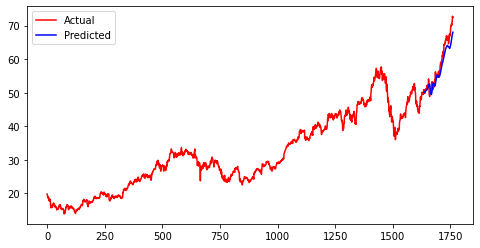

In [ ]:
pred = scaler.inverse_transform(model.predict(X_test))
fig, ax = plt.subplots(figsize=(8, 4))
plt.plot(df, color='red',  label='Actual')
ax.plot(range(len(y_train) + 50, len(y_train) + 50 + len(pred)), pred, color='blue', label='Predicted')
plt.legend()

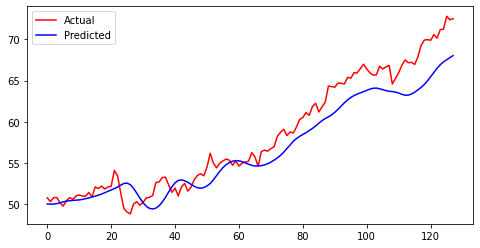

In [ ]:
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

fig, ax = plt.subplots(figsize=(8,4))
ax.plot(y_test_scaled, color='red', label='Actual')
plt.plot(pred, color='blue', label='Predicted')
plt.legend()

In [ ]:
print('MSE (normalized)', model.evaluate(X_test, y_test, verbose=0))
print('MSE: ', mean_squared_error(scaler.inverse_transform(y_test.reshape(-1, 1)), pred))

MSE (normalized) 0.002876011887565255
MSE:  5.527271116777465
